In [1]:
import os
import sys
import copy
import functools
from pathlib import Path
import torch
import numpy as np
import pandas as pd
from collections import defaultdict
from collections.abc import Mapping
import ml_collections
from omegaconf import OmegaConf
from hydra.utils import instantiate
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from joblib import Parallel, delayed
from joblib import parallel_config

import torch
# torch.utils.data.datapipes.utils.common.DILL_AVAILABLE = torch.utils._import_utils.dill_available()
import torchdata

from l3m.helpers import utils_scaling_law, utils_notebook, utils_misc
from l3m.helpers.utils_approachIII import *
from l3m.helpers.utils_scalinglaw_plots import *

import seaborn as sns
from scipy.stats import linregress
from matplotlib.colors import LogNorm
import plotly.express as px
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import turibolt as bolt

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_style('whitegrid')

/Users/s_abnar/miniforge3/envs/l3m_core/lib/python3.11/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


In [30]:
df = pd.read_csv('../notebooks/valid_wand_logs_latest.csv')

df['ffn_target.granularity'] = df['ffn_target.granularity'].replace(np.nan, 1)
df['ffn_target.expansion_factor'] = df['ffn_target.expansion_factor'].fillna(df['ffn_target.num_experts'])
df['ffn_target.num_experts'] = df['ffn_target.num_experts'].fillna(df['ffn_target.expansion_factor'] * df['ffn_target.granularity'])
df['sparsity'] = 1.0 - (df['ffn_target.top_k'] / df['ffn_target.num_experts'])

In [3]:
def parse_wandb_run_eval(run, api, **kw):
    """
    Parse `run` data (history, config) into groups: metadata, optim, run, etc..
    """

    artifact = api.artifact(f'mlr_l3m/MLR_LLM_MOE_SCALING_LAW_EVAL/run-{run.id}-LLMEvals:v0')
    table = artifact.get("LLM Evals")
    eval_dict = table.get_dataframe().to_dict()
    
    eval_dict 
    
    parsed = {}
    
    parsed['metadata'] = {
        'username': run.user.username,
        'wandb_id': run.id,
        'bolt_id': run.metadata["host"].split('-')[1],
        'pretrained_id': run.summary['bolt_task_id'],
        'name': run.name,
        'state': run.state,
        'tags': run.tags,
    }
    parsed['summary'] = utils_misc.flatten_dictionary(run.summary)
    parsed['ds_eval_summary'] = eval_dict
    
    parsed = utils_misc.flatten_dictionary(parsed)

    return {'parsed': parsed}



wandb_project_map = {
    'ds_eval': 'mlr_l3m/MLR_LLM_MOE_SCALING_LAW_EVAL',
}

import wandb

wb_config = OmegaConf.load('../.wandb.yaml')
api_key = wb_config['api-key']
api = wandb.Api(overrides={'base_url':'https://mlr-wandb.corp.apple.com'}, api_key=api_key, timeout=20)


frames = {pname: utils_notebook.get_runs_dataframe('../.wandb.yaml', wandb_project_map[pname], 
                                                   states=['finished'], 
                                                   count_router_parameters=False,
                                                   parse_wandb_run_fn=functools.partial(parse_wandb_run_eval, api=api),
                                                   ) for pname in wandb_project_map}


Loaded 1194 total runs from Wandb.
Loaded 1167 total runs from Wandb after filtering.


wandb:   1 of 1 files downloaded.  
/var/folders/j7/6f308lm15hq4fpwcb8pg59n00000gn/T/ipykernel_41628/791126467.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  eval_dict = table.get_dataframe().to_dict()
wandb:   1 of 1 files downloaded.  
/var/folders/j7/6f308lm15hq4fpwcb8pg59n00000gn/T/ipykernel_41628/791126467.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  eval_dict = table.get_dataframe().to_dict()
wandb:   1 of 1 files downloaded.  
/var/folders/j7/6f308lm15hq4fpwcb8pg59n00000gn/T/ipykernel_41628/791126467.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  eval_dict = table.get_dataframe().to_dict()
wandb:   1 of 1 files downloaded.  
/var/folders/j7/6f308lm15hq4fpwcb8pg59n00000gn/T/ipykernel_41628/791126467.py:8: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  eval_dict = table.get_dataframe().to_dict()
wandb:   1 of 1 files downloaded.  
/var

In [121]:


eval_df = pd.concat(frames.values()).reset_index(drop=True)

In [123]:
merged_df = pd.merge(df, eval_df, left_on='metadata.bolt_id', right_on='metadata.pretrained_id', how='inner')

merged_df = merged_df[merged_df['flops.logged'].isin(['3e+20', '3e+19', '6e+19', '1e+21', '1e+20', '3e+21'])]
merged_df['float_flops'] = merged_df['flops.logged'].apply(float)

for category, eval_names in eval_data.items():
    for n in eval_names:
        merged_df[f'{n}_value'] = pd.json_normalize(merged_df[n])[0]

In [124]:
len(merged_df)

1151

In [125]:
df_merged = merged_df.groupby('metadata.pretrained_id').agg(lambda x: x.first_valid_index()).reset_index()
len(df_merged)

637

In [126]:
merged_df.to_csv('ds_us_df_latest.csv', index=False)

merged_df['sparsity'].unique()

array([0.25, 0.5 , 0.  , 0.98, 0.75, 0.9 , 0.95])

In [127]:
from scipy.spatial import Delaunay
import numpy as np
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit

def alpha_shape(points, alpha, only_outer=True):
    """
    Compute the alpha shape (concave hull) of a set of points.
    :param points: np.array of shape (n,2) points.
    :param alpha: alpha value.
    :param only_outer: boolean value to specify if we keep only the outer border
    or also inner edges.
    :return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are
    the indices in the points array.
    """
    assert points.shape[0] > 3, "Need at least four points"

    def add_edge(edges, i, j):
        """
        Add an edge between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer:
                # if both neighboring triangles are in shape, it's not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))

    tri = Delaunay(points)
    edges = set()
    # Loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.vertices:
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle
        # www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

def find_edges_with(i, edge_set):
    i_first = [j for (x,j) in edge_set if x==i]
    i_second = [j for (j,x) in edge_set if x==i]
    return i_first,i_second

def stitch_boundaries(edges):
    edge_set = edges.copy()
    boundary_lst = []
    while len(edge_set) > 0:
        boundary = []
        edge0 = edge_set.pop()
        boundary.append(edge0)
        last_edge = edge0
        while len(edge_set) > 0:
            i,j = last_edge
            j_first, j_second = find_edges_with(j, edge_set)
            if j_first:
                edge_set.remove((j, j_first[0]))
                edge_with_j = (j, j_first[0])
                boundary.append(edge_with_j)
                last_edge = edge_with_j
            elif j_second:
                edge_set.remove((j_second[0], j))
                edge_with_j = (j, j_second[0])  # flip edge rep
                boundary.append(edge_with_j)
                last_edge = edge_with_j

            if edge0[0] == last_edge[1]:
                break

        boundary_lst.append(boundary)
    return boundary_lst[0]


def lower_convex_hull(points):
    # Compute the convex hull
    hull = ConvexHull(points)

    # Get the points on the convex hull
    hull_points = points[hull.vertices]

    # Sort the convex hull points by their x-coordinate
    hull_points = hull_points[np.argsort(hull_points[:, 0])][::-1]

    # Get the leftmost and rightmost points
    leftmost_point = hull_points[0]
    rightmost_point = hull_points[-1]

    # Function to compute the cross product of vectors (used to find if a point is above the baseline)
    def cross_product(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    # Filter the points that lie on the upper convex hull
    upper_hull_points = [leftmost_point]
    for point in hull_points[1:]:
        if cross_product(leftmost_point, rightmost_point, point) >= 0:
            upper_hull_points.append(point)

    return np.array(upper_hull_points)


def upper_convex_hull(points):
    # Compute the convex hull
    hull = ConvexHull(points)

    # Get the points on the convex hull
    hull_points = points[hull.vertices]

    # Sort the convex hull points by their x-coordinate
    hull_points = hull_points[np.argsort(hull_points[:, 0])]

    # Get the leftmost and rightmost points
    leftmost_point = hull_points[0]
    rightmost_point = hull_points[-1]

    # Function to compute the cross product of vectors (used to find if a point is above the baseline)
    def cross_product(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    # Filter the points that lie on the upper convex hull
    upper_hull_points = [leftmost_point]
    for point in hull_points[1:]:
        if cross_product(leftmost_point, rightmost_point, point) >= 0:
            upper_hull_points.append(point)

    return np.array(upper_hull_points)



def powerlaw_equation(x, a, b, c):
    return a * np.power(x, b) + c


def loglinear_equation(x, a, b, c):
    return a * np.log(b*x) + c
    
def fitter_func(x, y, equation):
    popt, pcov = curve_fit(equation, x, y, maxfev=5000)

    y_fitted = equation(np.arange(min(x),max(x), 0.01), *popt)

    return {'fitted_line': (np.arange(min(x),max(x), 0.01), y_fitted),
            'coefficients': popt
            }

In [128]:
eval_data = {
    'language_understanding': [
        'ds_eval_summary.hellaswag_zeroshot (0-shot)',
        'ds_eval_summary.hellaswag (10-shot)',
        'ds_eval_summary.lambada_openai (0-shot)',
        'ds_eval_summary.winograd (0-shot)',
        'ds_eval_summary.winogrande (0-shot)'
    ],
    'symbolic_problem_solving': [
        'ds_eval_summary.agi_eval_lsat_ar (3-shot)',
        'ds_eval_summary.bigbench_operators (10-shot)',
        'ds_eval_summary.bigbench_dyck_languages (10-shot)'
    ],
    'world_knowledge': [
        'ds_eval_summary.arc_easy (10-shot)',
        'ds_eval_summary.arc_challenge (10-shot)',
        'ds_eval_summary.bigbench_qa_wikidata (10-shot)',
        'ds_eval_summary.jeopardy (10-shot)'
    ],
    'common_sense_reasoning': [
        'ds_eval_summary.commonsense_qa (10-shot)',
        'ds_eval_summary.openbook_qa (0-shot)',
        'ds_eval_summary.piqa (10-shot)',
        'ds_eval_summary.copa (0-shot)'
    ],
    'reading_comprehension': [
        'ds_eval_summary.squad (10-shot)',
        'ds_eval_summary.coqa (0-shot)',
        'ds_eval_summary.boolq (10-shot)'
    ]
}


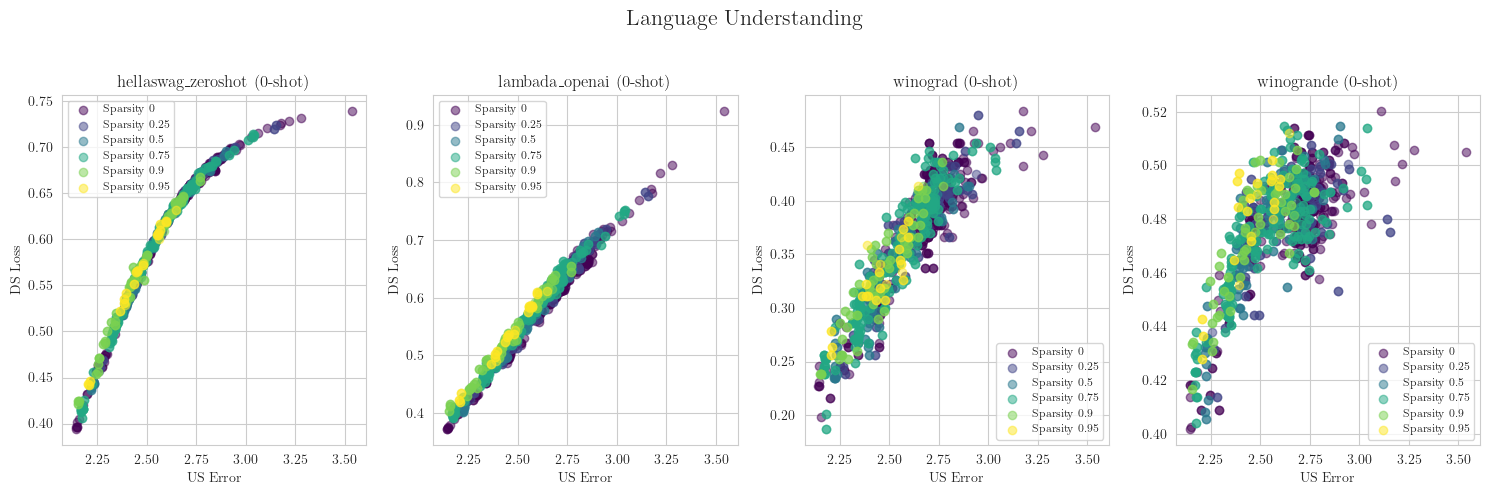

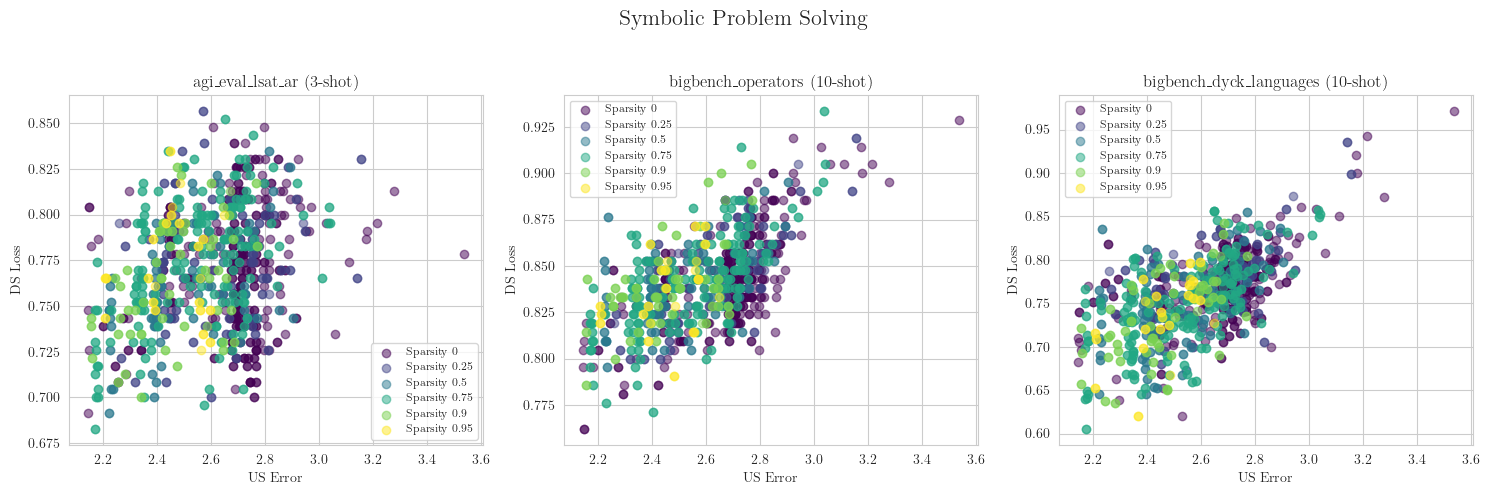

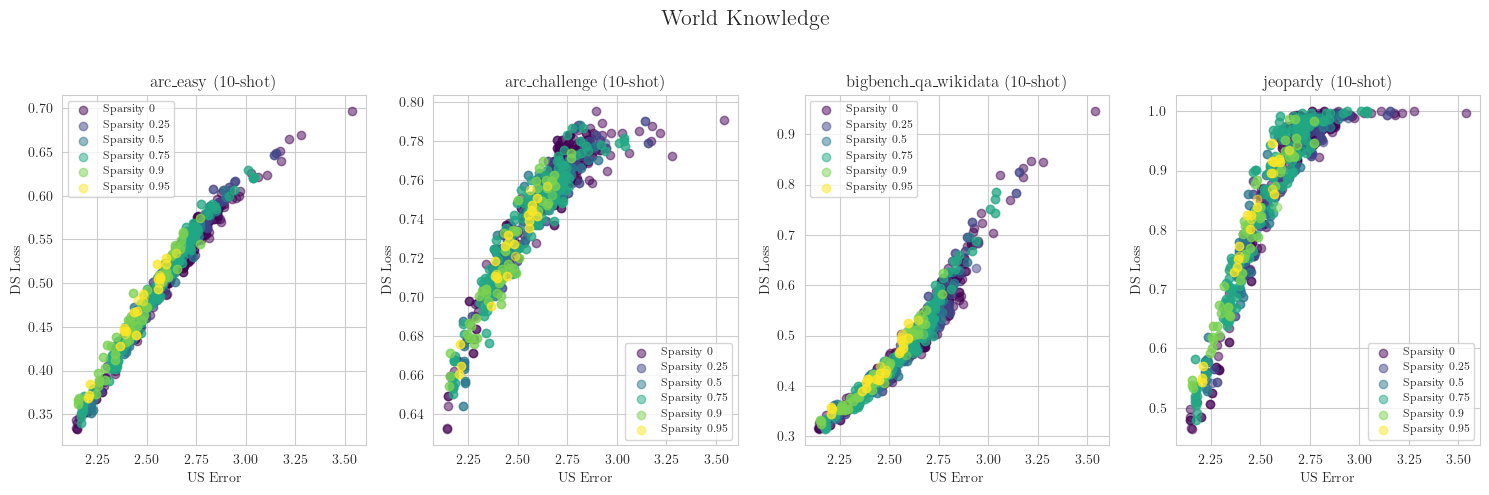

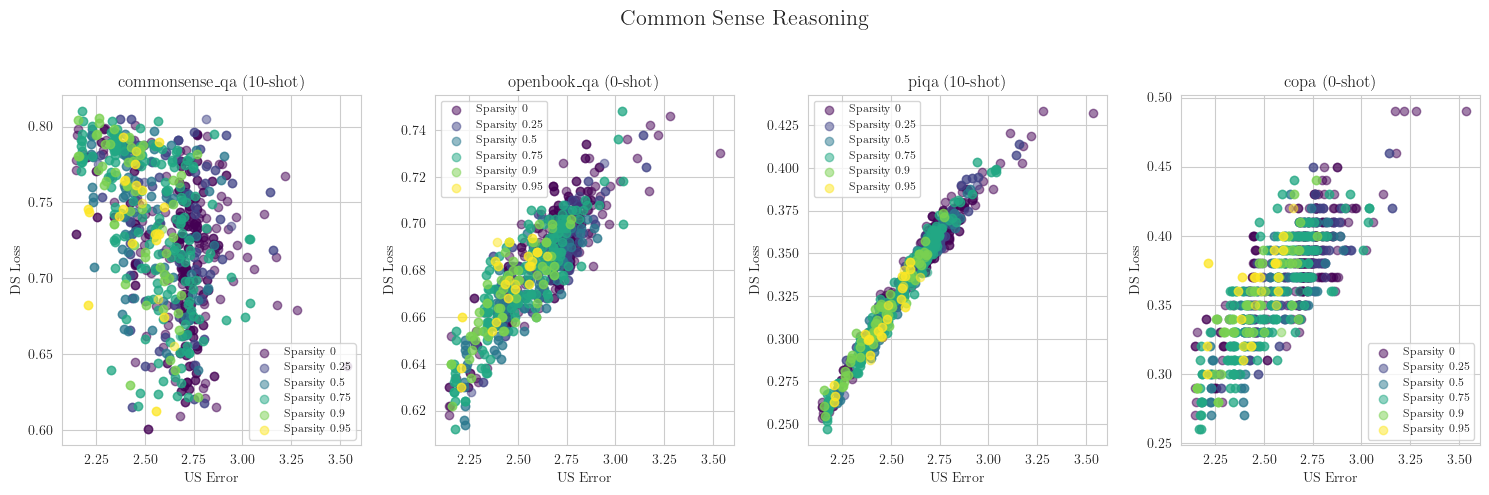

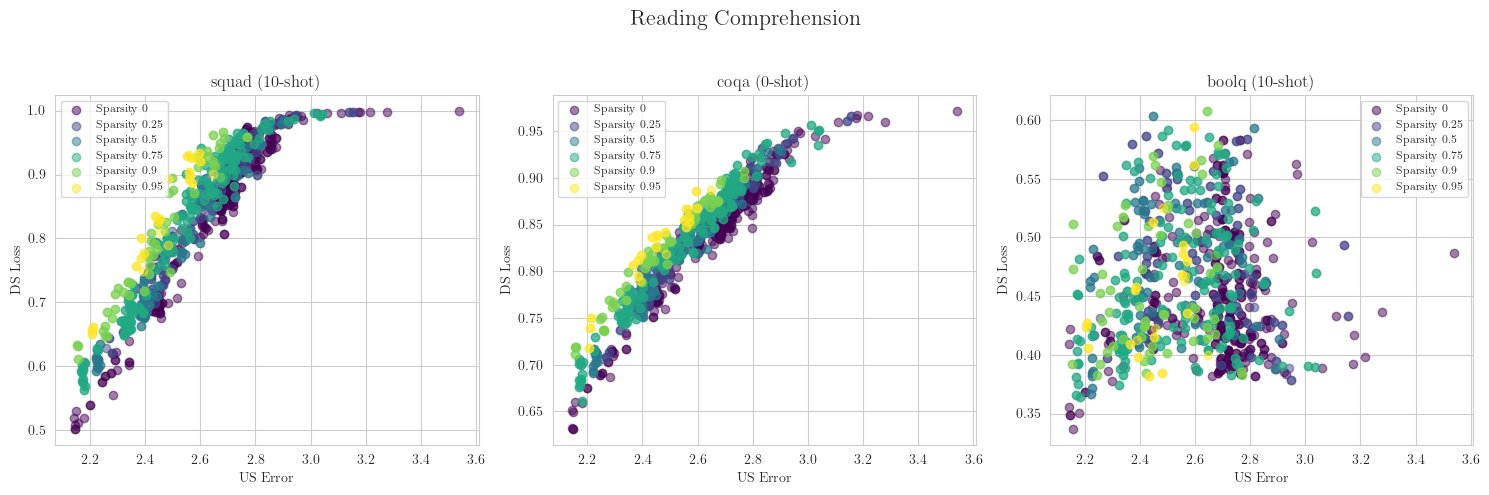

In [129]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # For colormap
import numpy as np
import pandas as pd
import alphashape
from shapely.geometry import Polygon, MultiLineString

# Set LaTeX font settings
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Define your evaluation names as a dictionary
eval_data = {
    'language_understanding': [
        'ds_eval_summary.hellaswag_zeroshot (0-shot)',
        # 'ds_eval_summary.hellaswag (10-shot)',
        'ds_eval_summary.lambada_openai (0-shot)',
        'ds_eval_summary.winograd (0-shot)',
        'ds_eval_summary.winogrande (0-shot)'
    ],
    'symbolic_problem_solving': [
        'ds_eval_summary.agi_eval_lsat_ar (3-shot)',
        'ds_eval_summary.bigbench_operators (10-shot)',
        'ds_eval_summary.bigbench_dyck_languages (10-shot)'
    ],
    'world_knowledge': [
        'ds_eval_summary.arc_easy (10-shot)',
        'ds_eval_summary.arc_challenge (10-shot)',
        'ds_eval_summary.bigbench_qa_wikidata (10-shot)',
        'ds_eval_summary.jeopardy (10-shot)'
    ],
    'common_sense_reasoning': [
        'ds_eval_summary.commonsense_qa (10-shot)',
        'ds_eval_summary.openbook_qa (0-shot)',
        'ds_eval_summary.piqa (10-shot)',
        'ds_eval_summary.copa (0-shot)'
    ],
    'reading_comprehension': [
        'ds_eval_summary.squad (10-shot)',
        'ds_eval_summary.coqa (0-shot)',
        'ds_eval_summary.boolq (10-shot)'
    ]
}

# Define sparsity levels and colormap
sparsity_levels = [0, 0.25, 0.50, 0.75, 0.90, 0.95]
colors = cm.viridis(np.linspace(0, 1, len(sparsity_levels)))  # Colormap for different sparsity levels

# Set fixed plot size and subplot size
fixed_figsize = (15, 5)  # Width, Height in inches
subplot_width = 5  # Width of each subplot
subplot_height = 4  # Height of each subplot

# Iterate over each category in the dictionary and create a separate plot for each
for category, eval_names in eval_data.items():
    num_cols = len(eval_names)  # Number of columns in the grid (adjust as needed)
    num_rows = int(np.ceil(len(eval_names) / num_cols))  # Automatically calculate the number of rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fixed_figsize)

    # Flatten axes for easier indexing (if 2D array of axes)
    axes = axes.flatten()

    # Loop over each dataset (eval_names) in the current category
    for i, n in enumerate(eval_names):
        ax = axes[i]

        # Loop over sparsity levels and plot each on the same subplot
        for sparsity_level, color in zip(sparsity_levels, colors):
            sparsity_x_data = merged_df[merged_df['sparsity'] == sparsity_level]
            
            if len(sparsity_x_data) > 1:
                # Prepare the points data
                points = np.asarray(list(zip(sparsity_x_data['loss.val_final'], 
                                             1.0 - pd.json_normalize(sparsity_x_data[n])[0])))
                try:
                    # Plot scatter points for each sparsity level with different colors
                    ax.scatter(points[:, 0], points[:, 1], label=f'Sparsity {sparsity_level}', color=color, alpha=0.5)
                    
                
                except Exception as e:
                    print(f"Error plotting {n} for sparsity level {sparsity_level}: {e}")
                    pass

        # Customize each subplot
        ax.set_xlabel(r'US Error')  # Use raw strings for LaTeX compatibility
        ax.set_ylabel(r'DS Loss')    # Use raw strings for LaTeX compatibility
        ax.set_title(f'{n.split(".")[-1]}', fontsize=12)
        # ax.set_xlim(0, 1)  # Adjust these limits as necessary
        # ax.set_ylim(0, 1)  # Adjust these limits as necessary
        ax.legend(loc='best', fontsize=8)

    # Remove unused axes if eval_names doesn't perfectly fill the grid
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    # Add a title to the entire figure for the current category
    plt.suptitle(f'{category.replace("_", " ").title()}', fontsize=16)

    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for suptitle
    plt.savefig(f'{category}_plots.pdf', format='pdf', bbox_inches='tight')

    plt.show()

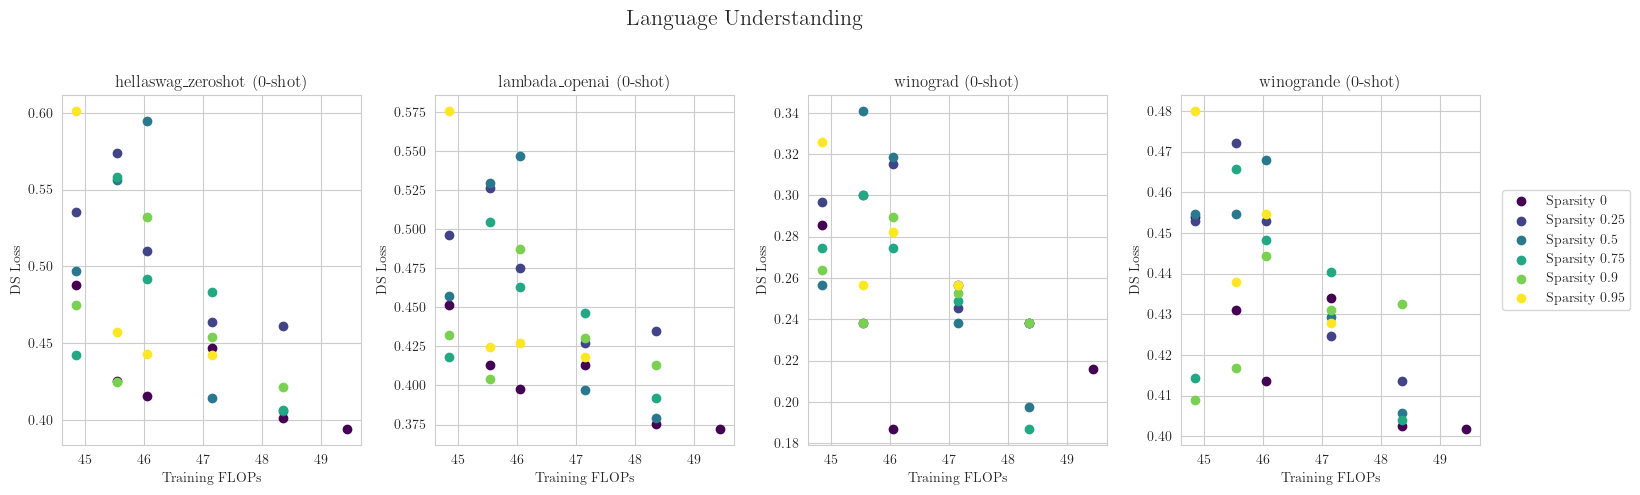

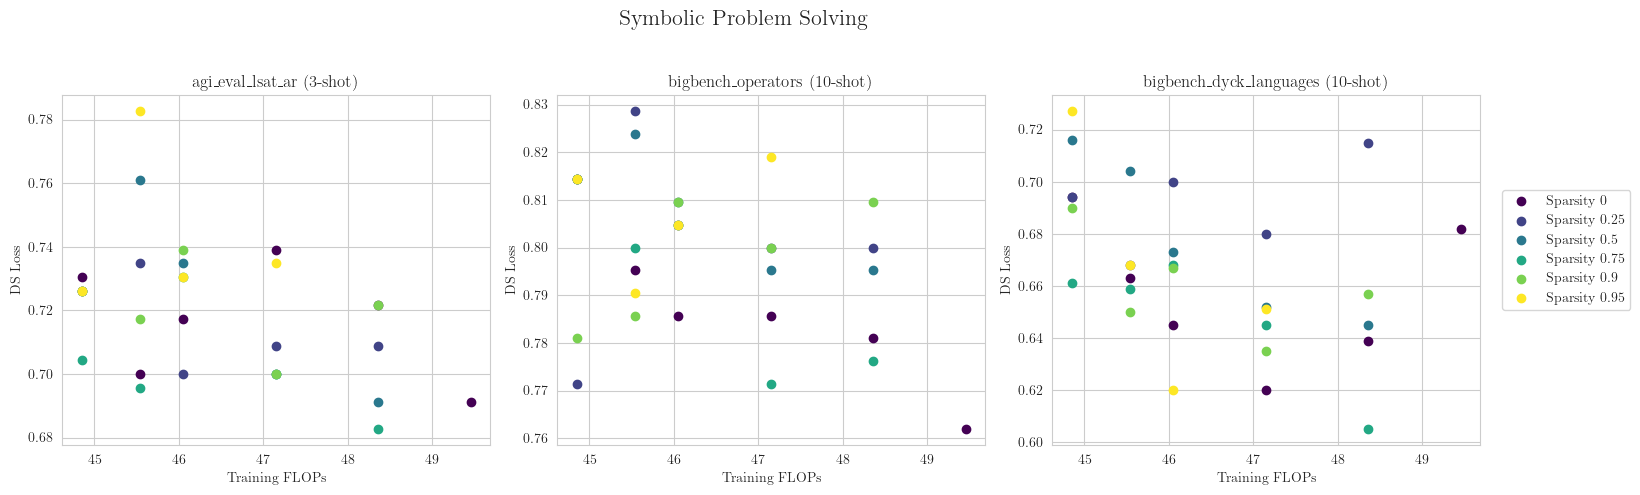

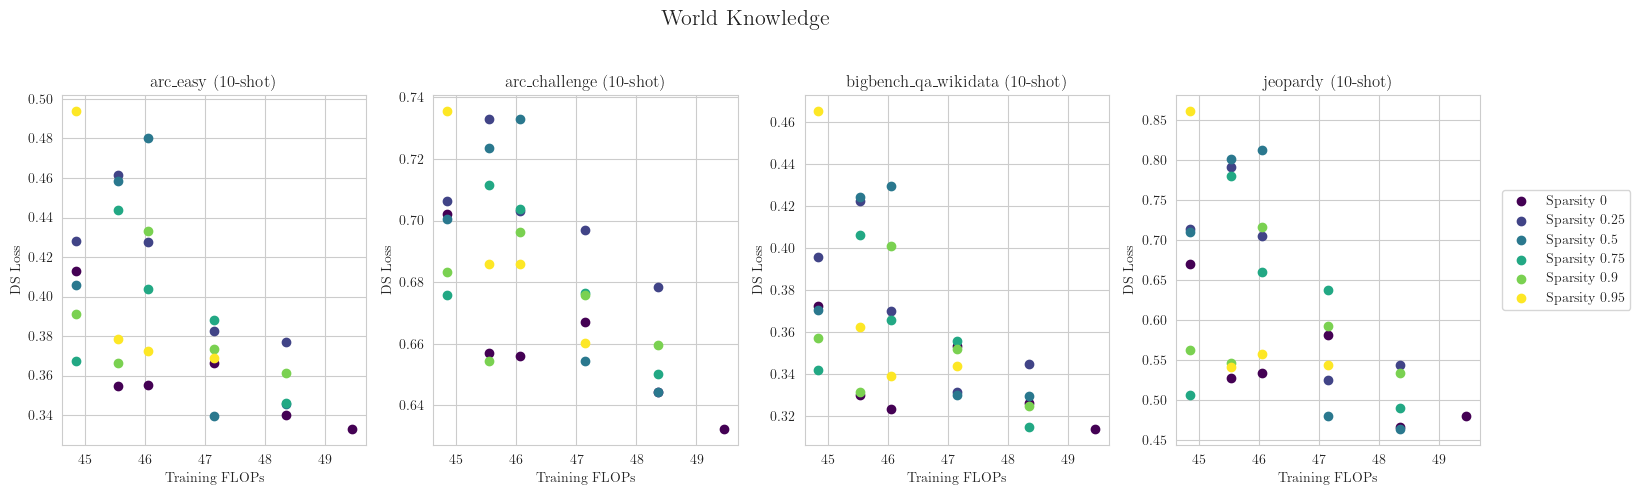

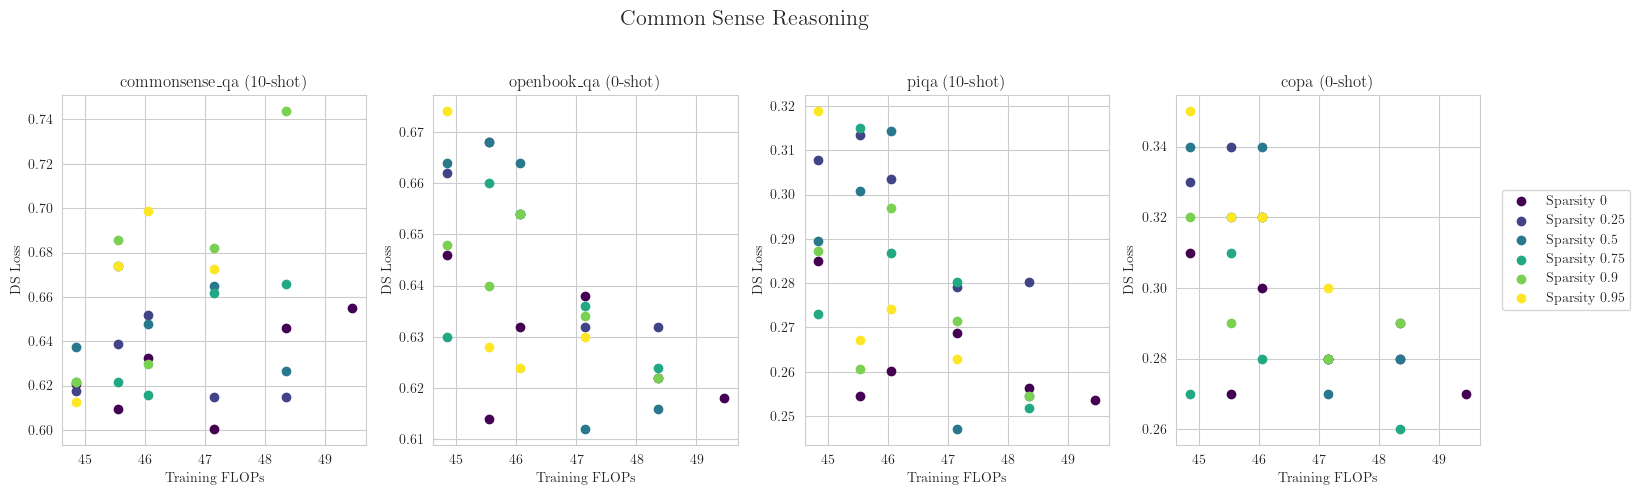

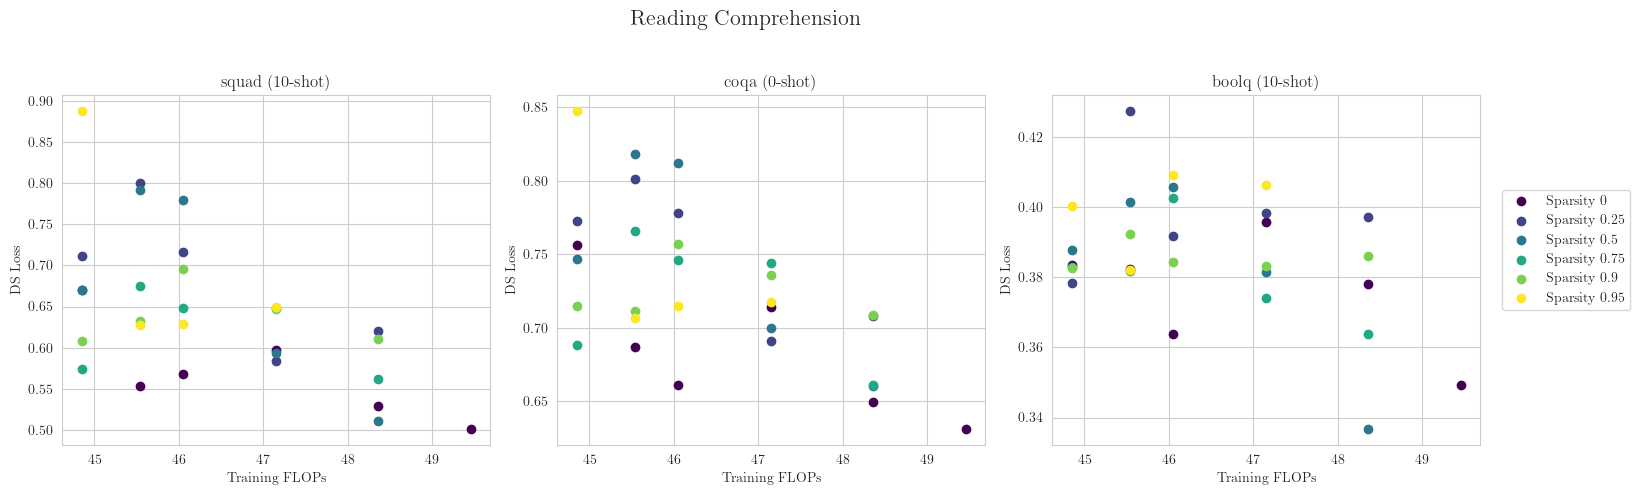

In [130]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # For colormap
import numpy as np
import pandas as pd
import alphashape
from shapely.geometry import Polygon, MultiLineString
from decimal import Decimal

# Set LaTeX font settings
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Define your evaluation names as a dictionary
eval_data = {
    'language_understanding': [
        'ds_eval_summary.hellaswag_zeroshot (0-shot)',
        # 'ds_eval_summary.hellaswag (10-shot)',
        'ds_eval_summary.lambada_openai (0-shot)',
        'ds_eval_summary.winograd (0-shot)',
        'ds_eval_summary.winogrande (0-shot)'
    ],
    'symbolic_problem_solving': [
        'ds_eval_summary.agi_eval_lsat_ar (3-shot)',
        'ds_eval_summary.bigbench_operators (10-shot)',
        'ds_eval_summary.bigbench_dyck_languages (10-shot)'
    ],
    'world_knowledge': [
        'ds_eval_summary.arc_easy (10-shot)',
        'ds_eval_summary.arc_challenge (10-shot)',
        'ds_eval_summary.bigbench_qa_wikidata (10-shot)',
        'ds_eval_summary.jeopardy (10-shot)'
    ],
    'common_sense_reasoning': [
        'ds_eval_summary.commonsense_qa (10-shot)',
        'ds_eval_summary.openbook_qa (0-shot)',
        'ds_eval_summary.piqa (10-shot)',
        'ds_eval_summary.copa (0-shot)'
    ],
    'reading_comprehension': [
        'ds_eval_summary.squad (10-shot)',
        'ds_eval_summary.coqa (0-shot)',
        'ds_eval_summary.boolq (10-shot)'
    ]
}

# Define sparsity levels and colormap
sparsity_levels = [0, 0.25, 0.50, 0.75, 0.90, 0.95]
colors = cm.viridis(np.linspace(0, 1, len(sparsity_levels)))  # Colormap for different sparsity levels
x_column = 'float_flops'
x_column_label = r'Training FLOPs'
x_transformer = lambda x: np.log(x) #np.log(x)


        


# Set fixed plot size and subplot size
fixed_figsize = (15, 5)  # Width, Height in inches
subplot_width = 5  # Width of each subplot
subplot_height = 4  # Height of each subplot

# Iterate over each category in the dictionary and create a separate plot for each
for category, eval_names in eval_data.items():
    num_cols = len(eval_names)  # Number of columns in the grid (adjust as needed)
    num_rows = int(np.ceil(len(eval_names) / num_cols))  # Automatically calculate the number of rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fixed_figsize)

    # Flatten axes for easier indexing (if 2D array of axes)
    axes = axes.flatten()
    legend_handles = []
    legend_labels = []
    
    # Loop over each dataset (eval_names) in the current category
    for i, n in enumerate(eval_names):
        ax = axes[i]

        # Loop over sparsity levels and plot each on the same subplot
        for sparsity_level, color in zip(sparsity_levels, colors):

            filter_df = merged_df.sort_values(f'{n}_value').groupby([x_column, 'sparsity']).last().reset_index()
            
            sparsity_x_data = filter_df[(filter_df['sparsity'] == sparsity_level)
            ]

            if len(sparsity_x_data) > 1:
                # Prepare the points data
                points = np.asarray(list(zip(x_transformer(sparsity_x_data[x_column]), 
                                             1.0 - sparsity_x_data[f'{n}_value'])))
                try:
                    # Plot scatter points for each sparsity level with different colors
                    scatter = ax.scatter(points[:, 0], points[:, 1], label=f'Sparsity {sparsity_level}', color=color, alpha=1.0)
                    
                    # Save handles and labels for the common legend
                    if i == 0:  # Only get the legend from the first subplot
                        legend_handles.append(scatter)
                        legend_labels.append(f'Sparsity {sparsity_level}')
                        
                except Exception as e:
                    print(f"Error plotting {n} for sparsity level {sparsity_level}: {e}")
                    pass

        # Customize each subplot
        ax.set_xlabel(x_column_label)  # Use raw strings for LaTeX compatibility
        ax.set_ylabel(r'DS Loss')    # Use raw strings for LaTeX compatibility
        ax.set_title(f'{n.split(".")[-1]}', fontsize=12)
   
        # ax.set_xlim(0, 1)  # Adjust these limits as necessary
        # ax.set_ylim(0, 1)  # Adjust these limits as necessary
        # ax.legend(loc='best', fontsize=8)

    # Remove unused axes if eval_names doesn't perfectly fill the grid
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    # Add a title to the entire figure for the current category
    plt.suptitle(f'{category.replace("_", " ").title()}', fontsize=16)

    fig.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=10)
    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for suptitle
    plt.savefig(f'{category}_plots.pdf', format='pdf', bbox_inches='tight')

    plt.show()

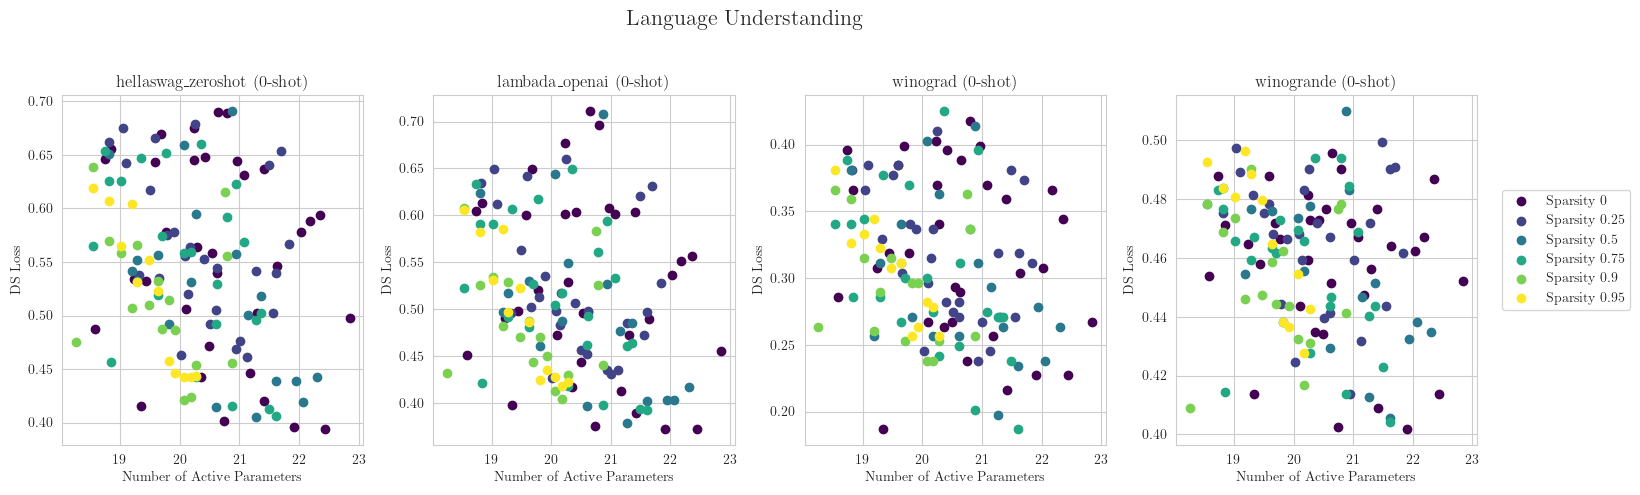

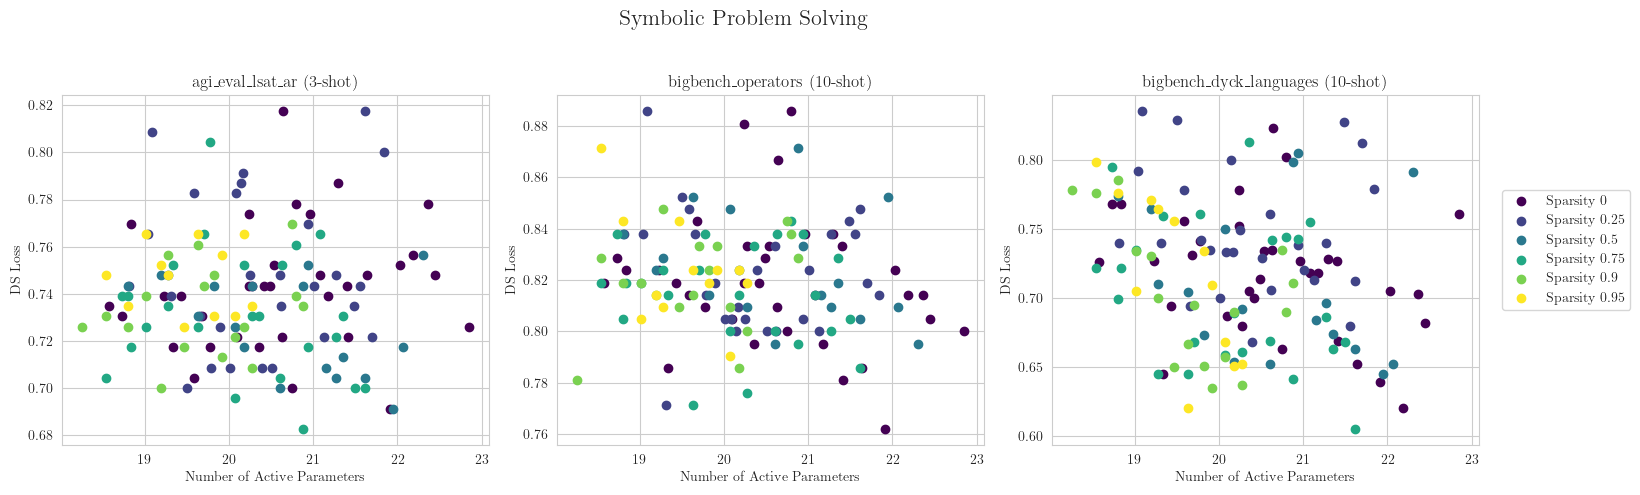

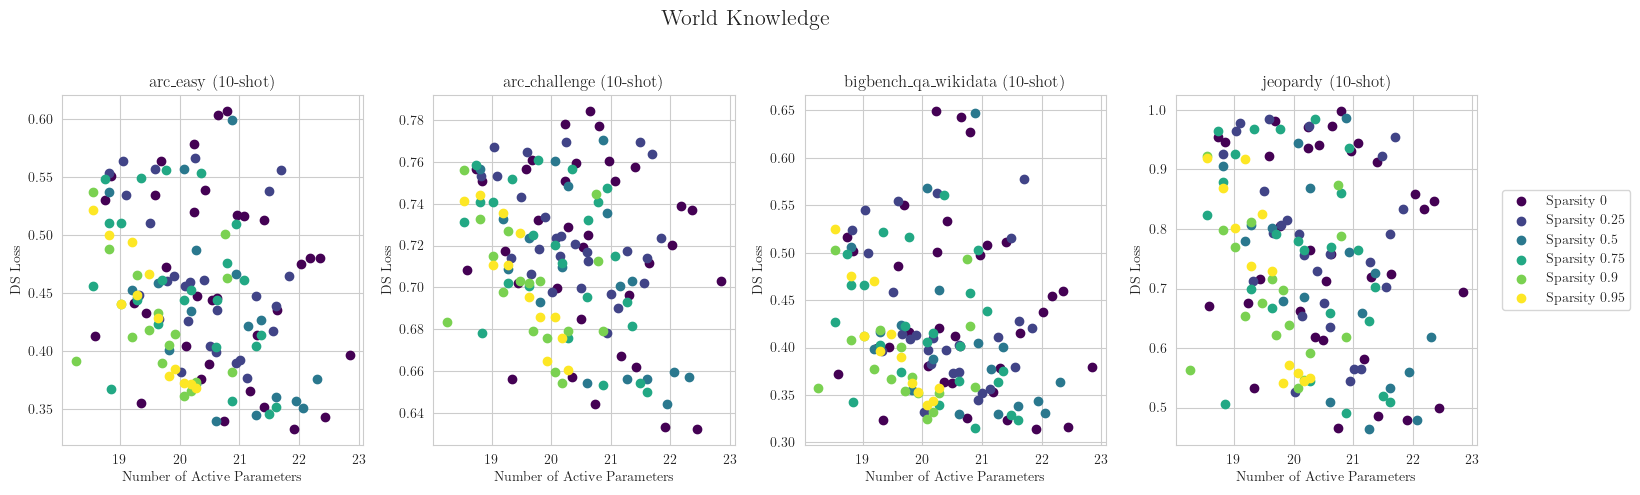

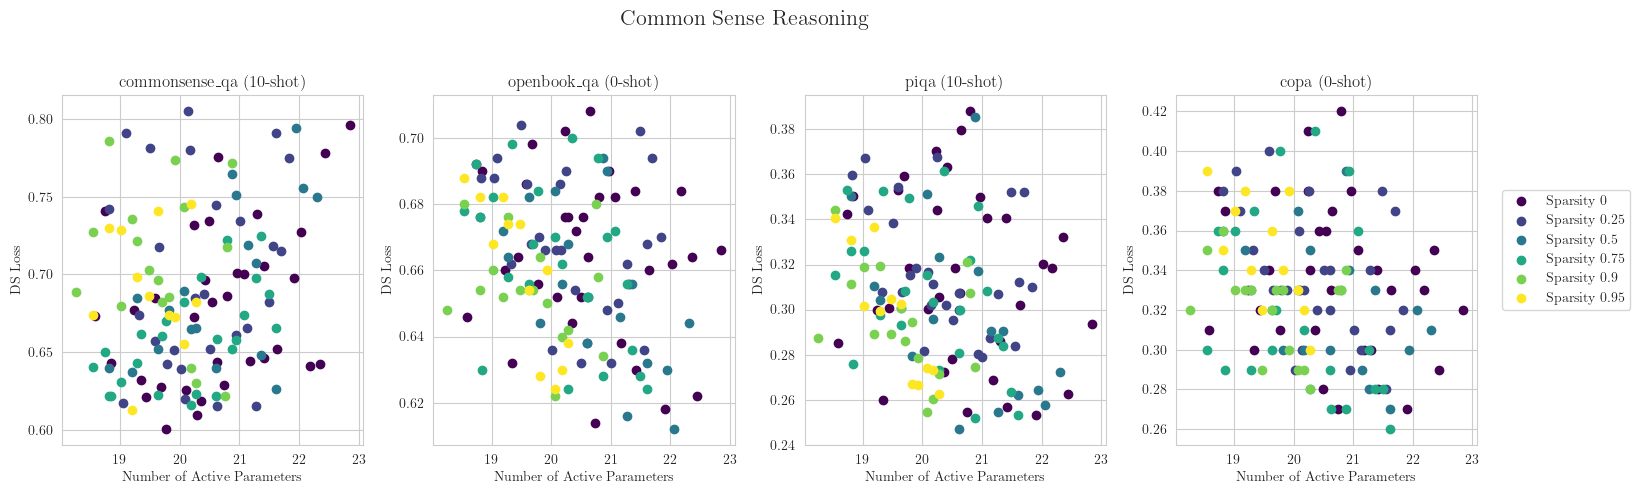

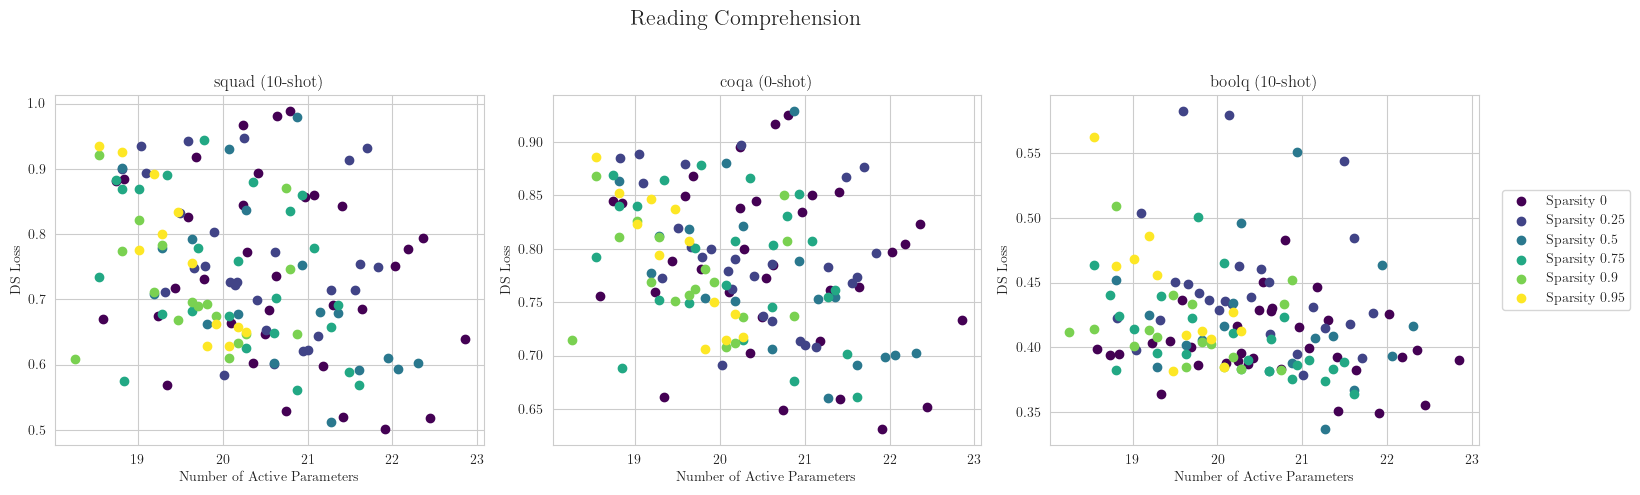

In [133]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # For colormap
import numpy as np
import pandas as pd
import alphashape
from shapely.geometry import Polygon, MultiLineString
from decimal import Decimal

# Set LaTeX font settings
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Define your evaluation names as a dictionary
eval_data = {
    'language_understanding': [
        'ds_eval_summary.hellaswag_zeroshot (0-shot)',
        # 'ds_eval_summary.hellaswag (10-shot)',
        'ds_eval_summary.lambada_openai (0-shot)',
        'ds_eval_summary.winograd (0-shot)',
        'ds_eval_summary.winogrande (0-shot)'
    ],
    'symbolic_problem_solving': [
        'ds_eval_summary.agi_eval_lsat_ar (3-shot)',
        'ds_eval_summary.bigbench_operators (10-shot)',
        'ds_eval_summary.bigbench_dyck_languages (10-shot)'
    ],
    'world_knowledge': [
        'ds_eval_summary.arc_easy (10-shot)',
        'ds_eval_summary.arc_challenge (10-shot)',
        'ds_eval_summary.bigbench_qa_wikidata (10-shot)',
        'ds_eval_summary.jeopardy (10-shot)'
    ],
    'common_sense_reasoning': [
        'ds_eval_summary.commonsense_qa (10-shot)',
        'ds_eval_summary.openbook_qa (0-shot)',
        'ds_eval_summary.piqa (10-shot)',
        'ds_eval_summary.copa (0-shot)'
    ],
    'reading_comprehension': [
        'ds_eval_summary.squad (10-shot)',
        'ds_eval_summary.coqa (0-shot)',
        'ds_eval_summary.boolq (10-shot)'
    ]
}

# Define sparsity levels and colormap
sparsity_levels = [0, 0.25, 0.50, 0.75, 0.90, 0.95]
colors = cm.viridis(np.linspace(0, 1, len(sparsity_levels)))  # Colormap for different sparsity levels
x_column = 'num_params.wo_embed_active'
x_column_label = r'Number of Active Parameters'
x_transformer = lambda x: np.log(x) #np.log(x)

for category, eval_names in eval_data.items():
    for n in eval_names:
        merged_df[f'{n}_value'] = pd.json_normalize(merged_df[n])[0]
        


# Set fixed plot size and subplot size
fixed_figsize = (15, 5)  # Width, Height in inches
subplot_width = 5  # Width of each subplot
subplot_height = 4  # Height of each subplot

# Iterate over each category in the dictionary and create a separate plot for each
for category, eval_names in eval_data.items():
    num_cols = len(eval_names)  # Number of columns in the grid (adjust as needed)
    num_rows = int(np.ceil(len(eval_names) / num_cols))  # Automatically calculate the number of rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=fixed_figsize)

    # Flatten axes for easier indexing (if 2D array of axes)
    axes = axes.flatten()
    legend_handles = []
    legend_labels = []
    
    # Loop over each dataset (eval_names) in the current category
    for i, n in enumerate(eval_names):
        ax = axes[i]

        # Loop over sparsity levels and plot each on the same subplot
        for sparsity_level, color in zip(sparsity_levels, colors):

            filter_df = merged_df.sort_values(f'{n}_value').groupby([x_column, 'sparsity']).last().reset_index()
            
            sparsity_x_data = filter_df[(filter_df['sparsity'] == sparsity_level)
            ]
            if len(sparsity_x_data) > 1:
                # Prepare the points data
                points = np.asarray(list(zip(x_transformer(sparsity_x_data[x_column]), 
                                             1.0 - sparsity_x_data[f'{n}_value'])))
                try:
                    # Plot scatter points for each sparsity level with different colors
                    scatter = ax.scatter(points[:, 0], points[:, 1], label=f'Sparsity {sparsity_level}', color=color, alpha=1.0)
                    
                    # Save handles and labels for the common legend
                    if i == 0:  # Only get the legend from the first subplot
                        legend_handles.append(scatter)
                        legend_labels.append(f'Sparsity {sparsity_level}')
                        
                except Exception as e:
                    print(f"Error plotting {n} for sparsity level {sparsity_level}: {e}")
                    pass

        # Customize each subplot
        ax.set_xlabel(x_column_label)  # Use raw strings for LaTeX compatibility
        ax.set_ylabel(r'DS Loss')    # Use raw strings for LaTeX compatibility
        ax.set_title(f'{n.split(".")[-1]}', fontsize=12)
   
        # ax.set_xlim(0, 1)  # Adjust these limits as necessary
        # ax.set_ylim(0, 1)  # Adjust these limits as necessary
        # ax.legend(loc='best', fontsize=8)

    # Remove unused axes if eval_names doesn't perfectly fill the grid
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j])

    # Add a title to the entire figure for the current category
    plt.suptitle(f'{category.replace("_", " ").title()}', fontsize=16)

    fig.legend(handles=legend_handles, labels=legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=10)
    # Adjust layout and display the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to leave space for suptitle
    plt.savefig(f'{category}_plots.pdf', format='pdf', bbox_inches='tight')

    plt.show()

### The rest for seeing which pretrained models we have not yet evaluated:

In [42]:
_merged_df = pd.merge(df, eval_df, left_on='metadata.bolt_id', right_on='metadata.pretrained_id', how='outer', indicator=True)
non_merged_rows = _merged_df[_merged_df['_merge'] != 'both']

len(non_merged_rows)

28

In [43]:
import re

pattern = re.compile(r'^checkpoint(_(\d+))?\.pth$')

def extract_number(file):
    match = pattern.match(file)
    if match:
        number = match.group(2)
        return int(number) if number else 0
    return 0
    
for i,d in non_merged_rows.iterrows():
    try:
        task = bolt.get_task(d['metadata.bolt_id_x'])
        files = list(task.artifacts.list())
        files = [file for file in files if pattern.match(file)]
        # print(files)
        files = sorted(files, key=extract_number)
        final_checkpoint = files[-1]
        last_checkpoint_iterations = extract_number(files[-1])
        # print(last_checkpoint_iterations, d['run.max_iterations'])
        if d['run.max_iterations'] == last_checkpoint_iterations:
            print(f"- {task.artifact_dir}/{final_checkpoint}")
        # print(f"- ['{d['metadata.botl_id']}',"+
        #       f"'iters:{utils_misc.make_number_human_readable(d['iteration'])}',"+
        #       f"'params:{utils_misc.make_number_human_readable(d['non_embed_params'])}',"+
        #       f"'tokens:{utils_misc.make_number_human_readable(d['total_tokens'])}',"+
        #       f"'flops:{'{:.1g}'.format(d['total_flops'])}']")
    except Exception as e:
        print(e)

- s3://bolt-prod-2700978698/tasks/739nqachux/artifacts/checkpoint_13190.pth
Cannot set bolt.GetTaskRequest.task_id to nan: nan has type <class 'float'>, but expected one of: (<class 'bytes'>, <class 'str'>) for field GetTaskRequest.task_id
Cannot set bolt.GetTaskRequest.task_id to nan: nan has type <class 'float'>, but expected one of: (<class 'bytes'>, <class 'str'>) for field GetTaskRequest.task_id
Cannot set bolt.GetTaskRequest.task_id to nan: nan has type <class 'float'>, but expected one of: (<class 'bytes'>, <class 'str'>) for field GetTaskRequest.task_id
Cannot set bolt.GetTaskRequest.task_id to nan: nan has type <class 'float'>, but expected one of: (<class 'bytes'>, <class 'str'>) for field GetTaskRequest.task_id
- s3://bolt-prod-973626361/tasks/e27kjbscd7/artifacts/checkpoint_4938.pth
Cannot set bolt.GetTaskRequest.task_id to nan: nan has type <class 'float'>, but expected one of: (<class 'bytes'>, <class 'str'>) for field GetTaskRequest.task_id
Cannot set bolt.GetTaskRequest